In [237]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv("data/train.csv", index_col=0)

In [4]:
test_data = pd.read_csv("data/test.csv", index_col=0)

In [5]:
train_data

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


In [6]:
test_data

,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


In [7]:
train_data.duplicated().sum()

2346

In [8]:
test_data.duplicated().sum()

505

In [9]:
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [10]:
train_data['gate_id'].sort_values().unique()

array([-1,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [11]:
test_data['gate_id'].sort_values().unique()

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [12]:
train_data['gate_id'].sort_values().value_counts()

 4     7980
 3     5220
 10    4767
 5     4554
 11    4090
 7     3026
 6     1741
 9     1729
 13    1087
 12     619
 15     298
-1       25
 8       24
 1        5
 16       4
 0        2
 14       1
Name: gate_id, dtype: int64

In [13]:
test_data['gate_id'].sort_values().value_counts()

 4     1431
 10     915
 3      893
 5      853
 11     762
 7      540
 9      394
 13     310
 6      282
 12     120
 15     102
 8       10
 2        4
 1        2
-1        1
 14       1
Name: gate_id, dtype: int64

In [14]:
gate_for_del = [-1, 0, 1, 2, 14, 16]

In [15]:
train_data['ts'] = pd.to_datetime(train_data['ts'])
test_data['ts'] = pd.to_datetime(test_data['ts'])

In [16]:
train_data['year'] = train_data['ts'].apply(lambda x: x.year)
train_data['weekday'] = train_data['ts'].apply(lambda x: x.isoweekday())
train_data['hour'] = train_data['ts'].apply(lambda x: x.hour)
train_data['minute'] = train_data['ts'].apply(lambda x: x.minute)
train_data['day'] = train_data['ts'].apply(lambda x: x.day)

In [17]:
train_data['week_number'] = train_data['ts'].dt.isocalendar().week


In [18]:
test_data['year'] = test_data['ts'].apply(lambda x: x.year)
test_data['weekday'] = test_data['ts'].apply(lambda x: x.isoweekday())
test_data['hour'] = test_data['ts'].apply(lambda x: x.hour)
test_data['minute'] = test_data['ts'].apply(lambda x: x.minute)
test_data['day'] = test_data['ts'].apply(lambda x: x.day)

In [19]:
test_data['week_number'] = test_data['ts'].dt.isocalendar().week

<Axes: ylabel='week_number'>

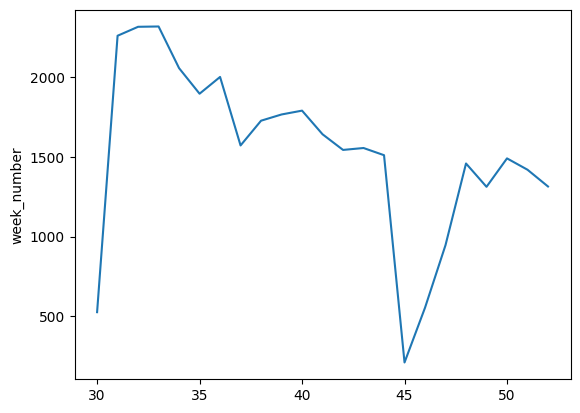

In [24]:
sns.lineplot(train_data['week_number'].value_counts().sort_index())

<Axes: xlabel='week_number', ylabel='Count'>

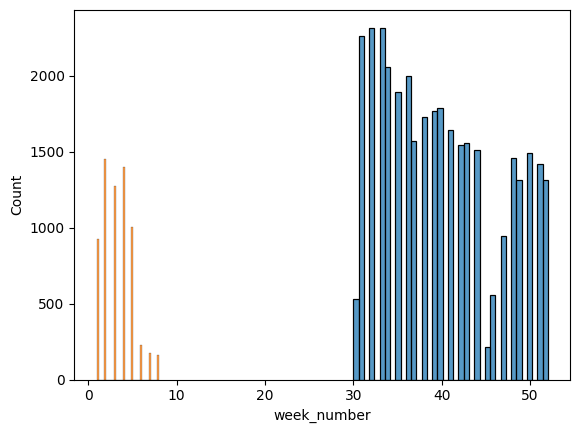

In [25]:
sns.histplot(train_data, x=train_data['week_number'])
sns.histplot(test_data, x=test_data['week_number'])

<Axes: xlabel='day', ylabel='Count'>

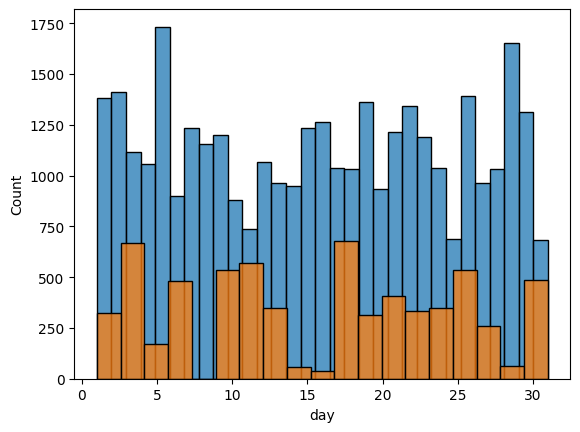

In [26]:
sns.histplot(train_data, x=train_data['day'])
sns.histplot(test_data, x=test_data['day'])

<Axes: xlabel='hour', ylabel='Density'>

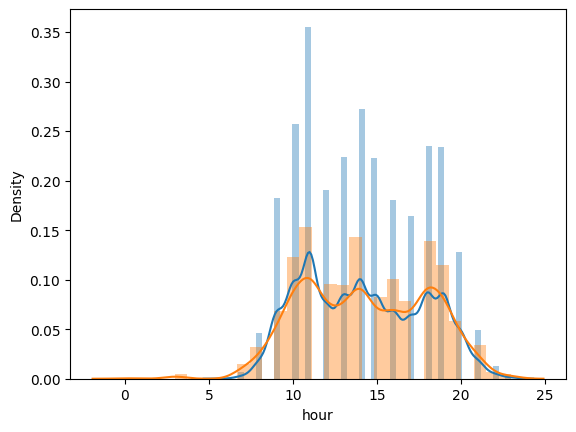

In [27]:
sns.distplot(train_data['hour'])
sns.distplot(test_data['hour'])

In [28]:
test_data

,ts,gate_id,user_word,year,weekday,hour,minute,day,week_number
37518,2023-01-03 08:21:00,9,gini,2023,2,8,21,3,1
37520,2023-01-03 08:21:18,5,gini,2023,2,8,21,3,1
37521,2023-01-03 08:21:19,5,gini,2023,2,8,21,3,1
37522,2023-01-03 08:21:39,10,gini,2023,2,8,21,3,1
37523,2023-01-03 08:32:49,15,epsilon,2023,2,8,32,3,1
...,...,...,...,...,...,...,...,...,...
44637,2023-02-24 17:08:57,10,collinear,2023,5,17,8,24,8
44638,2023-02-24 19:43:36,11,collinear,2023,5,19,43,24,8
44639,2023-02-24 19:44:00,4,collinear,2023,5,19,44,24,8
44640,2023-02-24 19:44:01,4,collinear,2023,5,19,44,24,8


In [29]:
train_data.shape

(35172, 9)

In [30]:
train_data = train_data.query('week_number != 45', engine='python')

In [31]:
train_data.shape

(34960, 9)

In [32]:
week_del_in_test = [6, 7, 8]

for i in week_del_in_test:
    test_data = test_data.query(f'week_number != {i}', engine='python')

In [33]:
test_data.shape

(6048, 9)

In [34]:
for i in gate_for_del:
    train_data = train_data.query(f'gate_id != {i}', engine='python')

In [35]:
test_data.shape

(6048, 9)

In [36]:
for i in gate_for_del:
    test_data = test_data.query(f'gate_id != {i}', engine='python')

In [37]:
train_data = train_data.drop(['ts', 'week_number'], axis=1)
test_data = test_data.drop(['ts', 'week_number'], axis=1)

In [38]:
train_data = train_data.drop(['year'], axis=1)
test_data = test_data.drop(['year'], axis=1)

In [39]:
train_data

,user_id,gate_id,weekday,hour,minute,day
0,18,7,5,9,8,29
1,18,9,5,9,9,29
3,18,5,5,9,10,29
4,18,5,5,9,10,29
5,18,10,5,9,10,29
...,...,...,...,...,...,...
37512,6,10,6,17,21,31
37513,6,11,6,20,38,31
37514,6,6,6,20,39,31
37515,6,6,6,20,39,31


In [40]:
test_data

,gate_id,user_word,weekday,hour,minute,day
37518,9,gini,2,8,21,3
37520,5,gini,2,8,21,3
37521,5,gini,2,8,21,3
37522,10,gini,2,8,21,3
37523,15,epsilon,2,8,32,3
...,...,...,...,...,...,...
43974,10,binary,5,20,59,3
43975,11,binary,5,21,4,3
43976,4,binary,5,21,4,3
43977,4,binary,5,21,4,3


In [41]:
train_data['weekday'].sort_values().unique()

array([1, 2, 3, 4, 5, 6, 7])

In [42]:
test_data['weekday'].sort_values().unique()

array([1, 2, 3, 4, 5, 6, 7])

In [43]:
work_day = [1, 2, 3, 4, 5]
weekend_day = [6, 7]

In [44]:
week_day = [work_day, weekend_day]
week_days_name = ['work_days', 'weekend_day']

In [45]:
count = 0

for i in week_day:
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    train_data[week_days_name[count]] = train_data['weekday'].apply(new_column)

    test_data[week_days_name[count]] = test_data['weekday'].apply(new_column)

    count += 1

In [46]:
train_data.shape

(34923, 8)

In [47]:
test_data.shape

(6040, 8)

In [48]:
np.sort(train_data['day'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [49]:
np.sort(test_data['day'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [50]:
day_lst = list((train_data['day'].sort_values().unique()))
day_lst = [int(x) for x in day_lst]
type(day_lst[2])

int

In [51]:
for i in range(len(day_lst)):
    def new_column(row):
        if day_lst[i] == row:
            return 1
        else:
            return 0

    train_data['day_' + str(i + 1)] = \
        train_data['day'].apply(new_column)

    test_data['day_' + str(i + 1)] = \
        test_data['day'].apply(new_column)

In [52]:
train_data.shape

(34923, 39)

In [53]:
test_data.shape

(6040, 39)

In [54]:
train_data['user_id'].unique()

array([18,  1,  3,  6, 29, 55, 24, 39, 47, 33,  0, 31, 37, 26, 50, 49, 53,
       20, 54, 19, 12, 46, 27, 25, 11, 15,  9, 48, 40, 56, 34, 22, 45, 23,
       57,  4,  8, 52, 32, 28,  7, 36, 42, 14, 35, 17,  5, 38, 41, 43, 10,
       51, 21, 30, 44,  2])

In [55]:
train_data['hour'].sort_values().unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])

In [56]:
test_data['hour'].sort_values().unique()

array([ 0,  1,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

In [58]:
hour_list = [0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [59]:
for i in range(len(hour_list)):
    def new_column(row):
        if hour_list[i] == row:
            return 1
        else:
            return 0

    train_data['hour_' + str(hour_list[i])] = train_data['hour'].apply(new_column)

    test_data['hour_' + str(hour_list[i])] = test_data['hour'].apply(new_column)

In [65]:
train_data.columns

Index(['user_id', 'gate_id', 'weekday', 'hour', 'minute', 'day', 'work_days',
       'weekend_day', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'day_31', 'hour_0', 'hour_1', 'hour_3',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [63]:
test_data.shape

(6040, 60)

In [73]:
night_hour = [0, 1, 3, 22, 23]
day_hour = [12, 13, 14, 15, 16, 17]
morning = [6, 7, 8, 9, 10, 11]
evening = [18, 19, 20, 21]

In [74]:
hour_day = [night_hour, day_hour, morning, evening]
hour_day_name = ['night_hour', 'day_hour', 'morning', 'evening']

In [75]:
count = 0

for i in hour_day:
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    train_data[hour_day_name[count]] = train_data['hour'].apply(new_column)

    test_data[hour_day_name[count]] = test_data['hour'].apply(new_column)

    count += 1

In [76]:
train_data.shape

(34923, 64)

In [77]:
test_data.shape

(6040, 64)

In [82]:
train_data['gate_id'].sort_values().unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15])

In [83]:
test_data['gate_id'].sort_values().unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15])

In [84]:
train_data['minute'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [85]:
test_data['minute'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [86]:
first_qt = [0, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]
second_qt = [15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
third_qt = [30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
forth_qt = [45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59]

In [87]:
half_hour = [first_qt, second_qt, third_qt, forth_qt]
hour_half_name = ['first_qt', 'ssecond_qt', 'third_qt', 'forth_qt']

In [88]:
count = 0

for i in half_hour:
    def new_column(row):
        if row in i:
            return 1
        else:
            return 0

    train_data[hour_half_name[count]] = train_data['minute'].apply(new_column)

    test_data[hour_half_name[count]] = test_data['minute'].apply(new_column)

    count += 1

In [89]:
train_data.shape

(34923, 68)

In [90]:
test_data.shape

(6040, 68)

In [91]:
gate_list = [3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15]

In [92]:
for i in range(len(gate_list)):
    def new_column(row):
        if gate_list[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train_data['gate_id_' + str(gate_list[i])] = train_data['gate_id'].apply(new_column)

    # создаем признак в датасете test
    test_data['gate_id_' + str(gate_list[i])] = test_data['gate_id'].apply(new_column)

In [93]:
train_data.shape

(34923, 80)

In [94]:
test_data.shape

(6040, 80)

In [97]:
list_weekday = np.sort(train_data['weekday'].unique())
list_weekday = [int(x) for x in list_weekday]

In [98]:
for i in range(len(list_weekday)):
    def new_column(row):
        if list_weekday[i] == row:
            return 1
        else:
            return 0

    # создаем признак в датасете train
    train_data['weekday_' + str(list_weekday[i])] = train_data['weekday'].apply(new_column)

    # создаем признак в датасете test
    test_data['weekday_' + str(list_weekday[i])] = test_data['weekday'].apply(new_column)

In [99]:
train_data.shape

(34923, 87)

In [100]:
test_data.shape

(6040, 87)

In [101]:
temp_train = pd.DataFrame(train_data.sum(), columns = ['sum_total'])
temp_train.loc[temp_train['sum_total'] == 0]

,sum_total
hour_0,0
hour_1,0
hour_3,0


In [102]:
temp_test = pd.DataFrame(test_data.sum(), columns = ['sum_total'])
temp_test.loc[temp_test['sum_total'] == 0]

,sum_total
day_8,0
hour_6,0


In [103]:
columns_to_del = (
    list(temp_train.loc[temp_train['sum_total'] == 0].index) +
    list(temp_test.loc[temp_test['sum_total'] == 0].index)
)
columns_to_del

['hour_0', 'hour_1', 'hour_3', 'day_8', 'hour_6']

In [105]:
train_data = train_data.drop(columns_to_del, axis = 1)
test_data = test_data.drop(columns_to_del, axis = 1)

In [106]:
train_data.shape

(34923, 82)

In [107]:
train_data.corr().style.background_gradient(cmap = 'magma')

In [108]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_data, 50))

Top Absolute Correlations
work_days    weekend_day    1.000000
hour_22      night_hour     0.895562
work_days    weekday_6      0.849164
weekend_day  weekday_6      0.849164
hour         morning        0.768788
minute       forth_qt       0.754544
hour         evening        0.748334
minute       first_qt       0.744058
weekday      weekday_1      0.699193
             weekday_5      0.645118
day_hour     morning        0.605233
hour_11      morning        0.577612
hour_19      evening        0.550509
hour_18      evening        0.550306
weekend_day  weekday_7      0.519422
work_days    weekday_7      0.519422
day_hour     evening        0.503698
gate_id      gate_id_3      0.485872
             gate_id_11     0.482927
hour_10      morning        0.481726
gate_id      gate_id_4      0.460643
hour_23      night_hour     0.442858
hour         hour_19        0.412833
gate_id      gate_id_10     0.403888
hour_20      evening        0.400274
hour_9       morning        0.398773
hour        

In [109]:
corr_del = [
    'weekend_day',
    'hour_22',
    'weekday_6'
]

In [110]:
train_data = train_data.drop(columns = corr_del, axis = 1)
test_data = test_data.drop(columns = corr_del, axis = 1)

In [111]:
train_data.shape

(34923, 79)

In [112]:
test_data.shape

(6040, 79)

<Axes: >

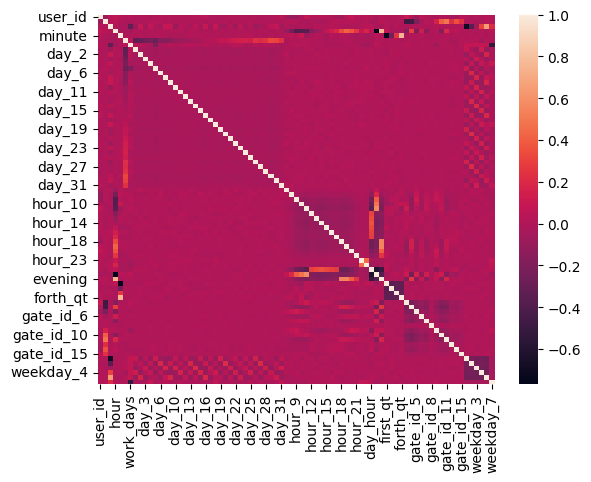

In [114]:
sns.heatmap(train_data.corr())

In [115]:
train_fatures = train_data.drop(columns = 'user_id')

In [116]:
train_fatures

,gate_id,weekday,hour,minute,day,work_days,day_1,day_2,day_3,day_4,...,gate_id_11,gate_id_12,gate_id_13,gate_id_15,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_7
0,7,5,9,8,29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,9,5,9,9,29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,5,5,9,10,29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,5,9,10,29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,10,5,9,10,29,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37512,10,6,17,21,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37513,11,6,20,38,31,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
37514,6,6,20,39,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37515,6,6,20,39,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
target = train_data['user_id']

In [118]:
test_features = test_data.drop(columns = 'user_word')

In [119]:
test_features.shape

(6040, 78)

In [120]:
target.unique()

array([18,  1,  3,  6, 29, 55, 24, 39, 47, 33,  0, 31, 37, 26, 50, 49, 53,
       20, 54, 19, 12, 46, 27, 25, 11, 15,  9, 48, 40, 56, 34, 22, 45, 23,
       57,  4,  8, 52, 32, 28,  7, 36, 42, 14, 35, 17,  5, 38, 41, 43, 10,
       51, 21, 30, 44,  2])

In [121]:
user_word = test_data['user_word']

In [226]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=1)


In [191]:
def search_best_estimator(pipeline, param_grid, x, y, ccvv):
    hrs = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='f1_weighted',
        cv=ccvv,
        n_candidates="exhaust",
        factor=5,
        random_state=1,
        n_jobs=-1,
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [272]:
pipeline = Pipeline(
    steps = [("base", RandomForestClassifier())]
)
param_grid = {
"base__n_estimators": [i for i in range(150,250,50)],
"base__max_depth": [i for i in range(25,35,5)],
"base__min_samples_split":[i for i in range(6,10,2)],
"base__min_samples_leaf": [2]
}
estimator = search_best_estimator(pipeline, param_grid, train_fatures, target, cv)

In [273]:
preds_train = estimator.predict(train_fatures)

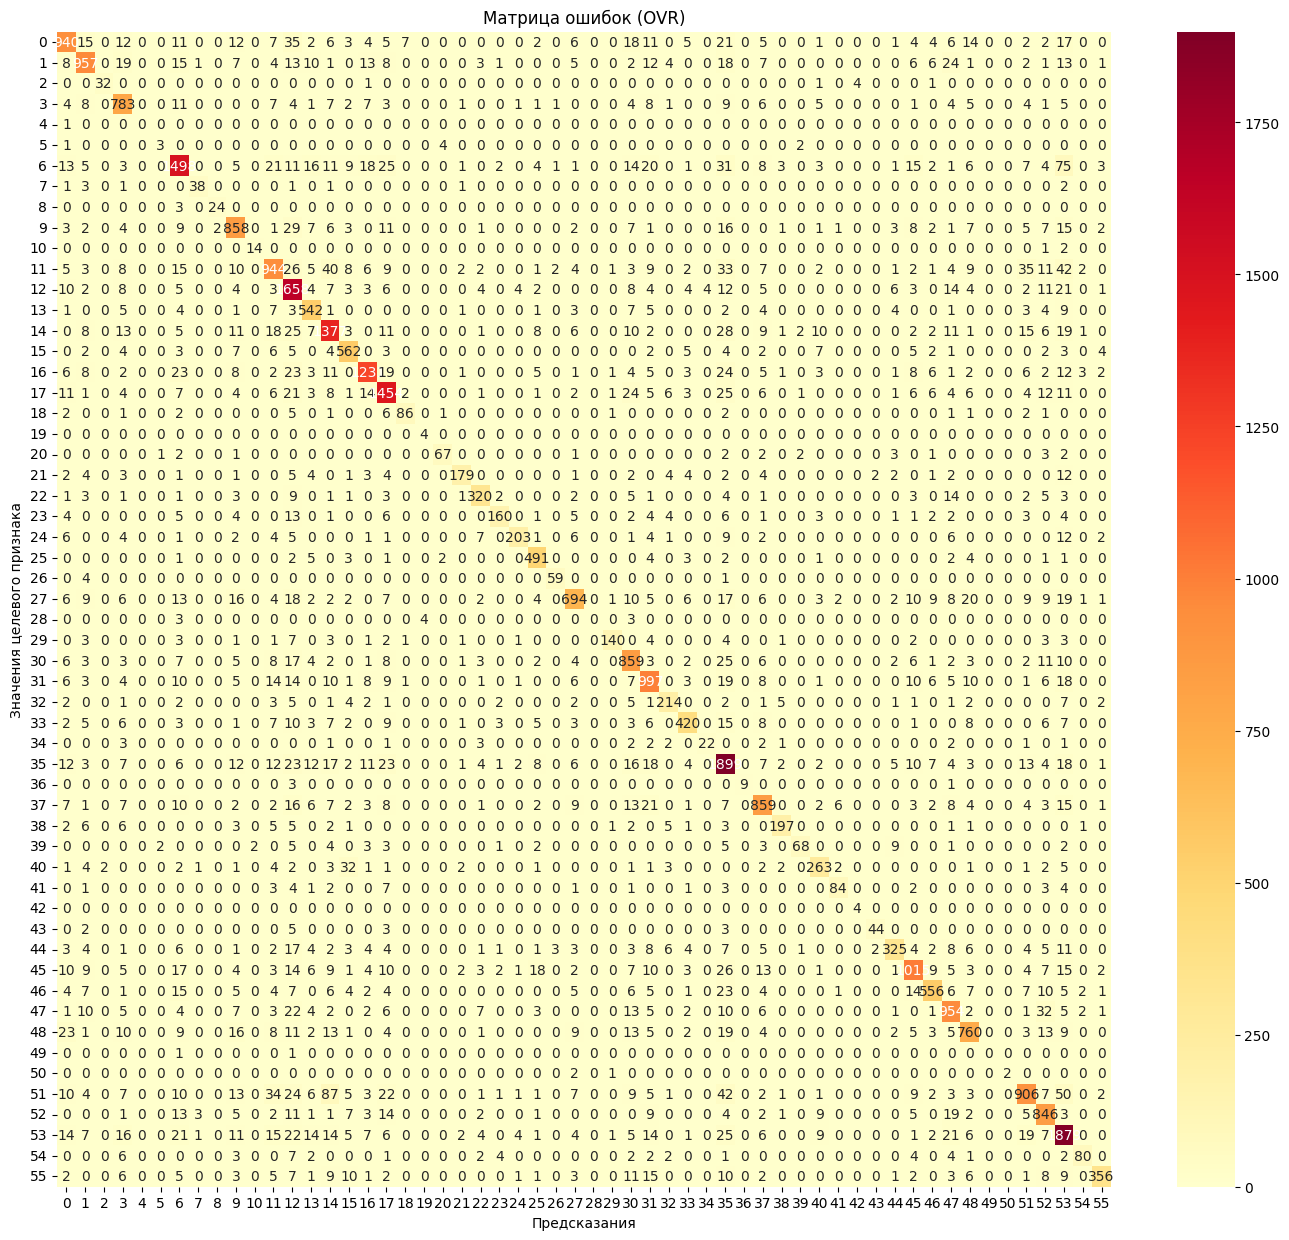

In [274]:
plt.figure(figsize = (17, 15))

confmatrix = confusion_matrix(
        target,
        preds_train)
f = sns.heatmap(confmatrix,
                annot = True,
                cmap = 'YlOrRd',
                fmt = 'g')

f.set_title('Матрица ошибок (OVR)')
f.set_xlabel('Предсказания')
f.set_ylabel('Значения целевого признака')
plt.yticks(rotation = 0)
plt.show()

In [275]:
predictions = estimator.predict(test_features)

In [276]:
print(classification_report(
    target,
    preds_train
))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1178
           1       0.86      0.82      0.84      1162
           2       0.94      0.82      0.88        39
           3       0.80      0.88      0.84       894
           4       0.00      0.00      0.00         1
           5       0.50      0.30      0.37        10
           6       0.84      0.82      0.83      1838
           7       0.86      0.79      0.83        48
           8       0.92      0.89      0.91        27
           9       0.82      0.85      0.83      1015
          10       0.88      0.82      0.85        17
          11       0.81      0.75      0.78      1254
          12       0.76      0.91      0.83      1822
          14       0.80      0.89      0.84       608
          15       0.82      0.85      0.83      1612
          17       0.83      0.89      0.86       633
          18       0.91      0.86      0.88      1432
          19       0.84    

In [277]:
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = predictions

In [278]:
submit.head()

,user_word,preds
37518,gini,3
37520,gini,3
37521,gini,3
37522,gini,1
37523,epsilon,18


In [279]:
submit_file = pd.DataFrame(submit.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

In [280]:
submit_file

,preds
user_word,
aucroc,49
binary,12
blue,55
categorical,14
coefficient,15
collinear,12
distributed,11
epsilon,1
f1,19


In [262]:
submit_file.to_csv('answer.csv')